In [10]:
import sys 
sys.path.append("C:/Users/isxzl/OneDrive/Code/VICReg-BarlowTwins-Ablation-Study/autoSSL")
import torchvision
from lightly.data import LightlyDataset, SimCLRCollateFunction, collate
import numpy as np
import tqdm
import yaml
import numpy as np
import torch
from tqdm import tqdm
import pytorch_lightning as pl
from autoSSL.evaluate import eval_KNN,eval_linear,eval_KNNplot
from autoSSL.models import BarlowTwins, BYOL, MoCo, SimCLR, SimSiam, VICReg,pipe_backbone
from autoSSL.utils import embedding_feature,ck_callback, pipe_model,dict2transformer,join_dir
from autoSSL.data import PipeDataset
from IPython.display import clear_output
from torchvision import transforms
from torchvision.transforms import RandomRotation,GaussianBlur,ColorJitter

### Config

In [ ]:
# Load the YAML file
with open('global.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Access the variables from the loaded YAML
num_workers = config['num_workers']
batch_size = config['batch_size']
memory_bank_size = config['memory_bank_size']
seed = config['seed']
device = config['device']
max_epochs = config['max_epochs']
input_size = config['input_size']
path_to_train = config['path_to_train']
path_to_test = config['path_to_test']

#pl.seed_everything(seed)
finetuning_augmentation = {
    'RandomCrop': {'size': input_size, 'padding': 4},
    'RandomHorizontalFlip': {},
    'ToTensor': {},
    'Normalize': {
        'mean': collate.imagenet_normalize["mean"],
        'std': collate.imagenet_normalize["std"]
    }
}
test_augmentation = {
    'ToTensor': {},
    'Normalize': {
        'mean': collate.imagenet_normalize["mean"],
        'std': collate.imagenet_normalize["std"]
    }
}

### Test Config



In [9]:
dict2transformer(SSL_augmentation,view=1)

Compose(
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomApply(
    p=0.8
    GaussianBlur(kernel_size=(3, 3), sigma=(0.2, 2))
)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomGrayscale(p=0.2)
    RandomSolarize(threshold=128,p=0.1)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# 1 Test Dataset

In [ ]:
# Model 1

# MAKE YOUR OWN CONFIG
config=global_config
SSL_augmentation=global_SSL_augmentation
config["name"]="batch_1"
config["max_epochs"]=config["max_epochs"]+3

# THIS IS THE CODE TO SAVE THE CONFIG FILE
config["log_dir"]=join_dir(config["checkpoint_dir"],config["experiment"],config["name"])
with open(join_dir(config["log_dir"], "config.yaml"), 'w') as yaml_file:
    yaml.dump(config, yaml_file, default_flow_style=False)

# THIS IS THE CODE TO LOAD DATASET
pdata= PipeDataset(input_dir=config["dataset_dir"],
    augmentation=dict2transformer(SSL_augmentation,view=config["view"]), samples=config["samples"],batch_size=config["batch_size"], 
    shuffle=config["shuffle"], drop_last=config["drop_last"], num_workers=config["num_workers"])

# THIS IS THE CODE TO LOAD MODEL
pmodel=pipe_model(name=config["model"],
           backbone=config["backbone"], stop_gradient=config["stop_gradient"],prjhead_dim=config["prjhead_dim"])

# THIS IS THE CODE TO TRAIN
trainer = pl.Trainer(
    max_epochs=config["max_epochs"]+3,accelerator=config["device"], 
    callbacks=[ck_callback(config["log_dir"])],
    logger=ContinuousCSVLogger(save_dir=config["log_dir"],name=config["name"])
)
#trainer.fit(pmodel, pdata.dataloader) 

# FOR LOAD PREVIOUS WEIGHT
trainer.fit(pmodel, pdata.dataloader,ckpt_path=(join_dir(config["log_dir"],"checkpoints-epoch=02-train_loss=20.89.ckpt")))  


### Test lightly Augmentation

===MultiViewTransform accept single Image===
view num:3
torch.Size([3, 32, 32])
===lightly transform accept single Image===
view num:2
torch.Size([3, 32, 32])
===lightly collate_fn accept batched Image List===
view num:2
torch.Size([2, 3, 32, 32])
tensor([0, 1])
['my-image.png', 'my-image2.png']


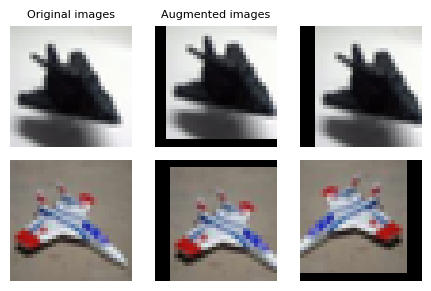

In [8]:
from lightly.transforms import SimCLRTransform,FastSiamTransform,VICRegTransform
import glob
from PIL import Image
import lightly
from torchvision.transforms import ToPILImage
import torch

from lightly.transforms.multi_view_transform import MultiViewTransform
from lightly.data import ImageCollateFunction, LightlyDataset, collate
from lightly.data.multi_view_collate import  MultiViewCollate
from lightly.data.collate import BaseCollateFunction
from lightly.utils.debug import plot_augmented_images

input_size=32
# let's get all jpg filenames from a folder
glob_to_data = r"C:\Users\isxzl\OneDrive\Code\Datasets\cifar10\train\airplane/*.png"
fnames = glob.glob(glob_to_data)

image = torch.randn(32, 3, input_size, input_size)
input_images = [Image.open(fname) for fname in fnames[:2]]
pil_image = ToPILImage()(image[0]) # Converts the first image of the batch to a PIL Image.
pil_image2 = input_images[0]
input = [(pil_image2, 0, 'my-image.png'),(pil_image, 1, 'my-image2.png')]


transf = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(input_size, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
    ]
)
 
transform = SimCLRTransform(
    input_size=input_size,   # resize input images to 128x128 pixels
    cj_prob=0.0,      # disable color jittering
    rr_prob=0.5,      # apply random rotation by 90 degrees with 50% probability
)

transform = FastSiamTransform(
    input_size=input_size,
    gaussian_blur=0.0,
)
transform = VICRegTransform(
    input_size=input_size,
    gaussian_blur=0.0,
)

mtransform = MultiViewTransform([transf, transf, transf])


mviews = mtransform(pil_image2)    #   --> n
print("===MultiViewTransform accept single Image===")
print(f"view num:{len(mviews)}")
print(mviews[0].shape)

views = transform(pil_image2)   # Accept Image
print("===lightly transform accept single Image===")
print(f"view num:{len(views)}")
print(views[0].shape)

collate_fn = SimCLRCollateFunction(     #   --> 2
    input_size=input_size,
    gaussian_blur=0.0,
)
collate_fn =BaseCollateFunction(transf)   # 1 --> 2



cviews=collate_fn(input)     # Accept batched Image List
print("===lightly collate_fn accept batched Image List===")
print(f"view num:{len(cviews[0])}")
print(cviews[0][0].shape)
print(cviews[1])
print(cviews[2])


fig = plot_augmented_images(input_images, collate_fn) 

### Test 2 views Augmentation of SSL

.pipe_data :1000
.dataset :1000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.90s/it]

.array :3
.array[0] :2


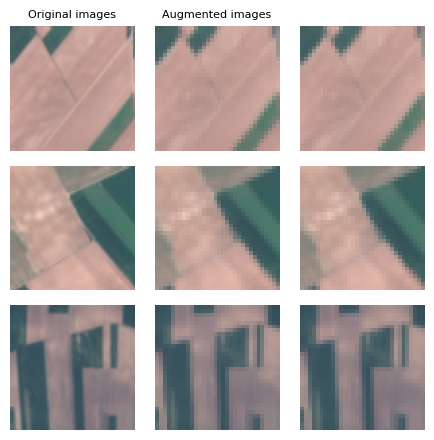

In [3]:
pipe_data_test =PipeDataset(
    input_dir=sentinel_ds, 
    augmentation=dict2transformer(test_augmentation,view=2), 
    samples=1000, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,    
 
)
pipe_data_test.plot([2,3,4])

print(f".pipe_data :{len(pipe_data_test)}")     # get dataset class
pipe_data_test[2]

pipe_data_test.dataloader  # get dataloader  
print(f".dataset :{len(pipe_data_test.dataset)}")     # get dataset class
temp=pipe_data_test.array
print(f".array :{len(temp)}")       #get array.
print(f".array[0] :{len(temp[0])}")       #get array.

#clear_output()

### Test PipeDataset of Single view

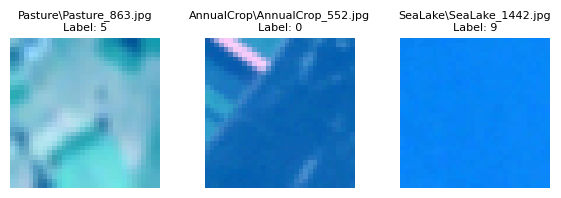

.pipe_data :1000
.dataset :1000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.03s/it]

.array :3
.array[0] :1000


In [16]:
 pipe_data_test =PipeDataset(
    input_dir=sentinel_ds, 
    augmentation=dict2transformer(SSL_augmentation), 
    samples=1000, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,    
 
)

pipe_data_test.plot([2,3,4])

print(f".pipe_data :{len(pipe_data_test)}")     # get dataset class
pipe_data_test[2]

pipe_data_test.dataloader  # get dataloader  
print(f".dataset :{len(pipe_data_test.dataset)}")     # get dataset class
temp=pipe_data_test.array
print(f".array :{len(temp)}")       #get array.
print(f".array[0] :{len(temp[0])}")       #get array.

#clear_output()

### Test Split

In [ ]:
# Test Split

pipe_data_train =PipeDataset(
    input_dir=path_to_train, 
    #samples=1000, 
    augmentation=test_augmentation, 
    batch_size=batch_size,
    shuffle=True,
    #collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers,

)
train_pipe_dataset, val_pipe_dataset = pipe_data_train.split(0.8)

print(len(val_pipe_dataset))
print(len(train_pipe_dataset))
print(len(pipe_data_train))

# 2 Test Model

### Test Candidate ALL

In [ ]:
# Create a list of all the backbone names
backbones =  ["resnet18", "resnet18_pretrained", "resnet50", "resnet50_pretrained", 
             "efficientnet_b5", "efficientnet_b5_pretrained", "mobilenet_v3", 
             "mobilenet_v3_pretrained", "vit_64", "vit_224"]

# List of model names
model_list = ["MoCo", "BYOL", "SimCLR", "SimSiam", "BarlowTwins", "VICReg"]

# Image sizes
image_sizes = [64, 224]

# Parameters
stop_gradients = [False, True]
prjhead_dims = [None, 512, 1024]


### Test Case Mini
        

In [ ]:
# Test Model backbone
from utils import pipe_model
import torch
 
# Create a list of all the backbone names
backbones = ["resnet18" ]

# List of model names
model_list = ["BarlowTwins", "VICReg"]

# Image sizes
image_sizes = [64, 224]

# Parameters
stop_gradients = [False, True]
prjhead_dims = [None, 512]

# For each backbone name in the list
for backbone_name in backbones:
    # Pass the appropriate input image to each model and calculate the output
    for model_name in model_list:
        for img_size in image_sizes:
            for stop_gradient in stop_gradients:
                for prjhead_dim in prjhead_dims:
                    if (backbone_name == "vit_224" and img_size != 224) or (backbone_name == "vit_64" and img_size != 64):
                        print(f"Backbone: {backbone_ vbname} not compatiable with Image Size: {img_size}")
                        continue
                    image = torch.randn(32, 3, img_size, img_size)  # Assuming RGB image
                    model = pipe_model(name=model_name, backbone=backbone_name, stop_gradient=stop_gradient, prjhead_dim=prjhead_dim)
                    output = model(image)
                    # Print the output size
                    if model_name=="SimSiam":
                        print(f"Model: {model_name}, Backbone: {backbone_name}, Image Size: {img_size}, Stop Gradient: {stop_gradient}, Projection Head Dimension: {prjhead_dim}, Output1 shape: {output[0].shape}, Output2 shape: {output[1].shape}") 
                    else:
                        print(f"Model: {model_name}, Backbone: {backbone_name}, Image Size: {img_size}, Stop Gradient: {stop_gradient}, Projection Head Dimension: {prjhead_dim}, Output shape: {output.shape}")


### Test other parameters over model

In [ ]:
 
model=MoCo()
model=BYOL()
model=SimCLR()
model=SimSiam()
model=BarlowTwins()
model=VICReg()
model.to(device)
clear_output()

# Test Evaluation

In [7]:
# Test Evaluation

pipe_data_train =PipeDataset(
    input_dir=cifar10_train, 
    #samples=1000, 
    augmentation=dict2transformer(test_augmentation), 
    batch_size=batch_size,
    shuffle=True,
    #collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers,

)
pipe_data_test =PipeDataset(
    input_dir=cifar10_train, 
    #samples=1000, 
    augmentation=dict2transformer(test_augmentation), 
    batch_size=batch_size,
    shuffle=True,
    #collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers,

)
model=MoCo()
eval_linear(pipe_data_train,embedding_model=model,split=0.8,device="cuda") 
eval_linear(pipe_data_train,embedding_model=model,test=pipe_data_test,device="cuda") 
eval_KNN(pipe_data_train,embedding_model=model,split=0.8,device="cuda") 
eval_KNN(pipe_data_train,embedding_model=model,test=pipe_data_test,device="cuda")   
eval_KNNplot(pipe_data_test,embedding_model=model,samples=2,device="cuda")

Load the training dataset to array


  0%|                                                                                           | 0/78 [00:08<?, ?it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\isxzl\anaconda3\envs\AutoGPT\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\isxzl\anaconda3\envs\AutoGPT\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\isxzl\anaconda3\envs\AutoGPT\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\isxzl\anaconda3\envs\AutoGPT\lib\site-packages\torch\utils\data\dataset.py", line 298, in __getitem__
    return self.dataset[self.indices[idx]]
  File "C:\Users\isxzl\anaconda3\envs\AutoGPT\lib\site-packages\lightly\data\dataset.py", line 238, in __getitem__
    sample, target = self.dataset.__getitem__(index)
  File "C:\Users\isxzl\anaconda3\envs\AutoGPT\lib\site-packages\torchvision\datasets\folder.py", line 231, in __getitem__
    sample = self.transform(sample)
TypeError: 'dict' object is not callable
